### Data Model for the LILA dataset Bbox evaluation
The dataset is available on the [site](http://lila.science/datasets)

The bounding box list given in the dataset has the encodings in the form  [x, y, width, height] which is:
- x: xmin
- y: ymin

The standard values needed for tensorflow api can be derived as:
- xmin: x
- ymin: y
- xmax: x+width
- ymax: y+height

Here, we are trying to create a TFRecord file that can be fed into the object deection API

In [1]:
# importing libraries needed to process the lila dataset
import os, sys, csv
import json
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf

from sklearn.model_selection import train_test_split # for splitting the data into train and eval

sys.path.append('/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/')
from utils import dataset_util
#Added this to handle the truncation error while decoding the jpeg
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
"""read the json file from the LILA: Snapshot Serengeti into a dictionary
The dictionary keys are:
annotations: this the bounding box level annotations
images: Information of the image
info: dataset creator information
categories: has a mapping similar to the label map

"""
with open('../data/LILA/SnapshotSerengetiBboxes_20190409.json', 'r') as f:
    dict1 = json.load(f)
    
# read the bounding box annotations and the image information to dataframes
df_annotations = pd.DataFrame(dict1['annotations'])
# Removing the unknown category from the dataset
df_annotations = df_annotations.loc[df_annotations['category_id']!=1000]
print("Annotation df shape: ", df_annotations.shape)
df_images = pd.DataFrame(dict1['images'])
print("Images df shape: ", df_images.shape)
df_categories = pd.DataFrame(dict1['categories'])
print("Categories df shape: ", df_categories.shape)
# df_images['image_id'] = df_images['file_name'][:-4]

Annotation df shape:  (147026, 4)
Images df shape:  (82938, 10)
Categories df shape:  (4, 2)


**Checking the contents of the json file**

In [6]:
df_annotations.head()

,bbox,category_id,id,image_id
0,"[214.55868530274304, 626.8372802734388, 199.89...",1,ltXUS1533042297365,S1/B05/B05_R1/S1_B05_R1_PICT0056
1,"[704.3220825195315, 685.3982543945319, 160.852...",1,V07ye1533042318001,S1/B05/B05_R1/S1_B05_R1_PICT0056
2,"[1026.6082763671961, 678.6542358398361, 153.12...",1,3H2B81533042352489,S1/B05/B05_R1/S1_B05_R1_PICT0056
3,"[1157.5803871154994, 650.5258425474201, 166.77...",1,SakJl1533042384693,S1/B05/B05_R1/S1_B05_R1_PICT0056
4,"[1445.725693901394, 733.3094338575975, 223.270...",1,7gIF41533042462350,S1/B05/B05_R1/S1_B05_R1_PICT0056


In [7]:
df_images.head()

,datetime,file_name,frame_num,height,id,location,season,seq_id,seq_num_frames,width
0,2010-10-08 12:45:34,S1/D05/D05_R5/S1_D05_R5_PICT1288.JPG,2,1536,S1/D05/D05_R5/S1_D05_R5_PICT1288,D05,S1,ASG0002uz2,3,2048
1,2013-03-26 11:47:57,S6/E03/E03_R2/S6_E03_R2_IMAG1342.JPG,1,1536,S6/E03/E03_R2/S6_E03_R2_IMAG1342,E03,S6,ASG000yrit,3,2048
2,2012-05-18 15:29:26,S5/E02/E02_R1/S5_E02_R1_IMAG0672.JPG,1,1536,S5/E02/E02_R1/S5_E02_R1_IMAG0672,E02,S5,ASG000ofxi,3,2048
3,2012-12-14 09:59:30,S6/C09/C09_R1/S6_C09_R1_IMAG0070.JPG,2,1536,S6/C09/C09_R1/S6_C09_R1_IMAG0070,C09,S6,ASG000yaqx,3,2048
4,2011-05-01 17:10:40,S2/K03/K03_R2/S2_K03_R2_IMAG0116.JPG,0,1536,S2/K03/K03_R2/S2_K03_R2_IMAG0116,K03,S2,ASG000789s,3,2048


In [8]:
df_categories.head()

,id,name
0,1,animal
1,2,person
2,3,group
3,4,vehicle


#### Bringing in the species level information from metadata

In [10]:
Project_filepath = "/home/ubuntu/data/tensorflow/my_workspace/training_demo/"

df_consensus_data = pd.read_csv((Project_filepath +'Data/consensus_data.csv'))
print('Concensus Data: ', df_consensus_data.shape)
df_all_images = pd.read_csv((Project_filepath +'Data/all_images.csv'))
print('all_images Data: ', df_all_images.shape)

Concensus Data:  (334671, 19)
all_images Data:  (3198737, 2)


In [15]:
# Picking the single species images
df_consensus_data_single_species = df_consensus_data[df_consensus_data['NumSpecies']==1]
print('Shape of df: ', df_consensus_data_single_species.shape)
df_consensus_data_single_species.head()

Shape of df:  (305278, 19)


,CaptureEventID,NumImages,DateTime,SiteID,LocationX,LocationY,NumSpecies,Species,Count,Standing,Resting,Moving,Eating,Interacting,Babies,NumClassifications,NumVotes,NumBlanks,Evenness
0,ASG0002kjh,1,2010-07-18 16:26:14,B04,695238,9729497,1,human,1,0.625000,0.062500,0.000000,0.000000,0.500000,0.0,17,16,1,0.000000
1,ASG0002kji,1,2010-07-18 16:26:30,B04,695238,9729497,1,human,2,0.095238,0.619048,0.000000,0.047619,0.333333,0.0,23,21,2,0.000000
2,ASG0002kjm,1,2010-07-24 08:20:10,B04,695238,9729497,1,gazelleGrants,1,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,30,12,6,0.693426
3,ASG0002kjn,1,2010-07-24 10:14:32,B04,695238,9729497,1,reedbuck,1,0.833333,0.000000,0.166667,0.000000,0.000000,0.0,25,6,7,0.957995
4,ASG0002kjo,1,2010-07-30 03:59:42,B04,695238,9729497,1,dikDik,1,0.809524,0.000000,0.190476,0.000000,0.000000,0.0,28,21,3,0.482102


In [18]:
df_images_single_species = pd.merge(left=df_images,
                                    right=df_consensus_data_single_species[['CaptureEventID', 'Species']].drop_duplicates(),
                                    left_on='seq_id',
                                    right_on='CaptureEventID',
                                    how='inner'
                                   )
print("correct merge: ", df_images_single_species.drop_duplicates().shape==df_images_single_species.shape)
print("Shape if df_images_single_species: ", df_images_single_species.shape)
df_images_single_species.head(n=2)

correct merge:  True
Shape if df_images_single_species:  (79003, 12)


,datetime,file_name,frame_num,height,id,location,season,seq_id,seq_num_frames,width,CaptureEventID,Species
0,2010-10-08 12:45:34,S1/D05/D05_R5/S1_D05_R5_PICT1288.JPG,2,1536,S1/D05/D05_R5/S1_D05_R5_PICT1288,D05,S1,ASG0002uz2,3,2048,ASG0002uz2,waterbuck
1,2010-10-08 12:45:34,S1/D05/D05_R5/S1_D05_R5_PICT1287.JPG,1,1536,S1/D05/D05_R5/S1_D05_R5_PICT1287,D05,S1,ASG0002uz2,3,2048,ASG0002uz2,waterbuck


**Excluding the events that are present in Schneider's data and that were used for training round 0**: This is because Schneider's data is our test data and needs to be of elements that are not seen by the model while training.

In [20]:
df_schneider_box = pd.read_csv('/home/ubuntu/data/tensorflow/my_workspace/training_demo/Data/GoldStandardBoundBoxCoord.csv')
schneider_events = list(set(df_schneider_box['filename']))
schneider_events = [word.split('.')[0] for word in schneider_events] # [word[:-4] for word in schneider_events]
print("Images in Schneider dataset: ", len(schneider_events))

# Filtering out the images that are used in training the model
l = []
with open("../data/LILA/msi_image_names.csv",'r') as f:
    rd = csv.reader(f)
    for val in rd:
        l.append(val)
        
l = l[0]

exclude_images_list = list(set(schneider_events+l))
print(len(schneider_events)," + ", len(l), " = ", len(exclude_images_list))

Images in Schneider dataset:  4011
4011  +  38199  =  42210


#### Get category data from prior saved LILA

In [21]:
# Bringing in the label map
sys.path.append('/home/ubuntu/species_detection/my_workspace/training-species-detection/')
import dataset_tools.data_prep_utils as dataprep_utils

label_map_json = '/home/ubuntu/species_detection/my_workspace/training-species-detection/Data/label_map.json'
label_map = dataprep_utils.get_label_map_from_json(label_map_json)
label_map = pd.DataFrame.from_dict(label_map, orient='index').reset_index()
label_map.columns = ['class', 'label_map']
label_map = label_map.sort_values(by='label_map')
label_map.tail()


,class,label_map
16,genet,44
43,caracal,45
46,rhinoceros,46
22,reptiles,47
30,zorilla,48


In [22]:
print(set(df_consensus_data_single_species.Species).intersection(set(label_map['class'])))

{'elephant', 'jackal', 'wildcat', 'mongoose', 'eland', 'buffalo', 'batEaredFox', 'wildebeest', 'dikDik', 'hyenaStriped', 'giraffe', 'zebra', 'ostrich', 'hippopotamus', 'genet', 'civet', 'otherBird', 'bushbuck', 'serval', 'warthog', 'reptiles', 'baboon', 'guineaFowl', 'gazelleThomsons', 'porcupine', 'waterbuck', 'zorilla', 'gazelleGrants', 'aardvark', 'lionFemale', 'honeyBadger', 'koriBustard', 'hyenaSpotted', 'human', 'secretaryBird', 'reedbuck', 'vervetMonkey', 'rodents', 'aardwolf', 'topi', 'leopard', 'impala', 'hare', 'caracal', 'cheetah', 'hartebeest', 'rhinoceros', 'lionMale'}


**Creating the dictionary object that can feed into the function create_tf_example to generate TFRecord object**

In [27]:
"""The function create_tf_example takes in a dictionary as input. 
And so we need to preprocess the LILA dataset into the required format.
This dictionary has the following keys values:
{CaptureEventID: {'metadata' : {"SiteID": val,
                                "DateTime": val, 
                                "Season": val
                                },
                                'images' : [{"Path" : val), #points to the route of image on the disk
                                "URL" : val,
                                "dim_x" : val,
                                "dim_y" : val,
                                "image_label" : "tbd", # This is the image level label if any
                                'observations' : [{'bb_ymin': v['ymin'], 
                                                   'bb_ymax': v['ymax'], 
                                                   'bb_primary_label': v['class'], 
                                                   'bb_xmin': v['xmin'], 
                                                   'bb_xmax': v['xmax'], 
                                                   'bb_label': {"species" : v['class'], 
                                                                "pose" : "standing/ sitting/ running"
                                                                }
                                                   } for k, v in enumerate(gold_standard_bb[row[0]])
                                                   ]}
                               ]}
                                
"""

# Join the tables df_annotations and df_images
df_bb_meta = pd.merge(left=df_annotations, 
                      right=df_images_single_species, 
                      how='inner',
                      left_on=df_annotations['image_id'], 
                      right_on=df_images_single_species['id'])
df_bb_meta = df_bb_meta.drop(columns=['key_0', 'id_y', 'category_id'])

df_bb_meta = pd.merge(left=df_bb_meta, 
                      right=label_map, 
                      how='inner',
                      left_on=df_bb_meta['Species'], 
                      right_on=label_map['class'])
df_bb_meta = df_bb_meta.drop(columns=['key_0'])
print("Shape before removing overlapping images with schneider's data: ", df_bb_meta.shape)
df_bb_meta = df_bb_meta[~df_bb_meta['label_map'].isna()]
print("Shape after removing NA labels images: ", df_bb_meta.shape)
df_bb_meta['label_map'] = df_bb_meta['label_map'].astype(np.int64)

# Removing the overlapping images with Schneider's data
df_bb_meta = df_bb_meta[~df_bb_meta['seq_id'].isin(exclude_images_list)]
print("Shape after removing overlapping images with schneider's data: ", df_bb_meta.shape)

# Removing the overlapping images with data used in Round 0 training
df_bb_meta = df_bb_meta[~df_bb_meta['image_id'].isin(exclude_images_list)]
print("Shape after removing overlapping images with Round 0 training data: ", df_bb_meta.shape)

# renaming columns to match the prior Bbox version
df_bb_meta = df_bb_meta.rename(columns={'label_map': 'category_id', 'Species': 'name'})

# Converting the dataframe to th dictionary for convenience
dict_bb_meta = df_bb_meta.to_dict('records')

Shape before removing overlapping images with schneider's data:  (131196, 16)
Shape after removing NA labels images:  (131196, 16)
Shape after removing overlapping images with schneider's data:  (130574, 16)
Shape after removing overlapping images with Round 0 training data:  (60702, 16)


In [28]:
print('Dataframe size of the df_bb_meta is: {0}'.format(df_bb_meta.shape))
df_bb_meta.head(n=2)

Dataframe size of the df_bb_meta is: (60702, 16)


,bbox,id_x,image_id,datetime,file_name,frame_num,height,location,season,seq_id,seq_num_frames,width,CaptureEventID,name,class,category_id
13559,"[77.0, 273.0, 1266.0, 1166.1823730468811]",rDHq21541150780964,S1/B06/B06_R1/S1_B06_R1_PICT0008,2010-07-21 17:27:14,S1/B06/B06_R1/S1_B06_R1_PICT0008.JPG,0,1536,B06,S1,ASG000001a,1,2048,ASG000001a,elephant,elephant,11
13560,"[41.42523606618317, 1034.4473234812417, 317.19...",aZaB71541150857542,S1/B06/B06_R1/S1_B06_R1_PICT0037,2010-07-31 10:51:36,S1/B06/B06_R1/S1_B06_R1_PICT0037.JPG,0,1536,B06,S1,ASG0000023,1,2048,ASG0000023,elephant,elephant,11


#### Data Digging & Exploratory Analysis

In [29]:
df_image_species = df_bb_meta.drop_duplicates(['name', 'file_name'])
df_image_species = df_image_species[['name', 'file_name']]
df_image_species_freq = df_image_species.groupby(by=['name'], as_index=False).count()
df_image_species_freq = df_image_species_freq.sort_values(by='file_name')\
                            .rename(index=str, columns={'file_name':'freq'})

df_image_species_freq['freq_p'] = round((df_image_species_freq['freq']/df_images.shape[0])*100,2)

Text(0.5,0,'% of images out of a total 44739 images')

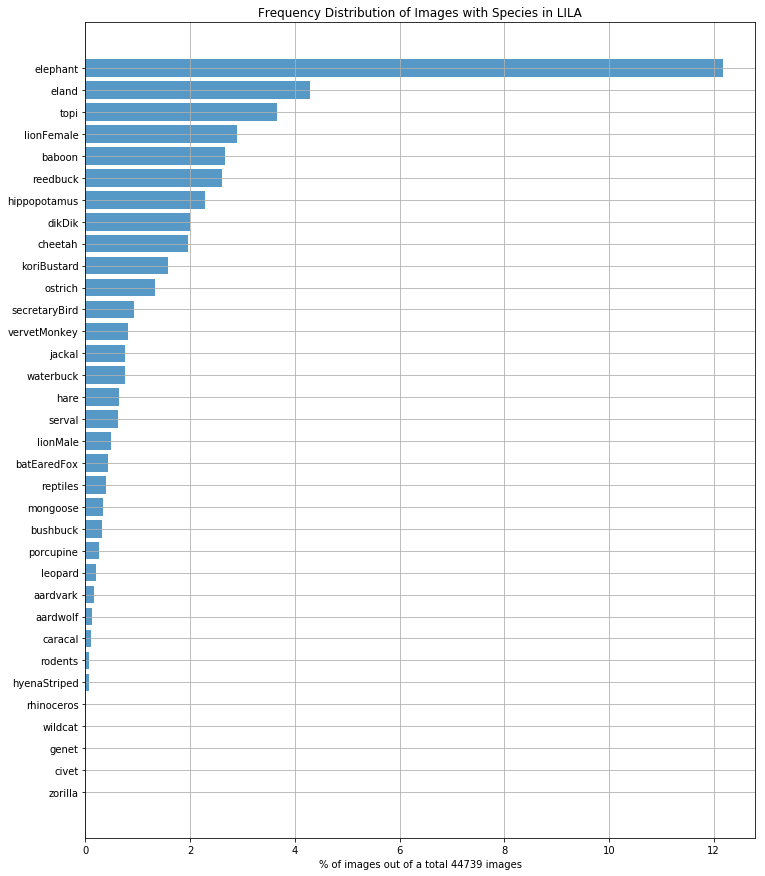

In [30]:
plt.figure(figsize=(12,15))
plt.grid(True)
plt.barh(df_image_species_freq['name'], df_image_species_freq['freq_p'], align='center', alpha=0.75)
plt.title('Frequency Distribution of Images with Species in LILA')
plt.xlabel('% of images out of a total {0} images'.format(df_images[~df_images['id'].isin(l)].shape[0]))

**Frequency bounding boxes per Species** 

Text(0.5,0,'Number of bounding box in a total 44739 images')

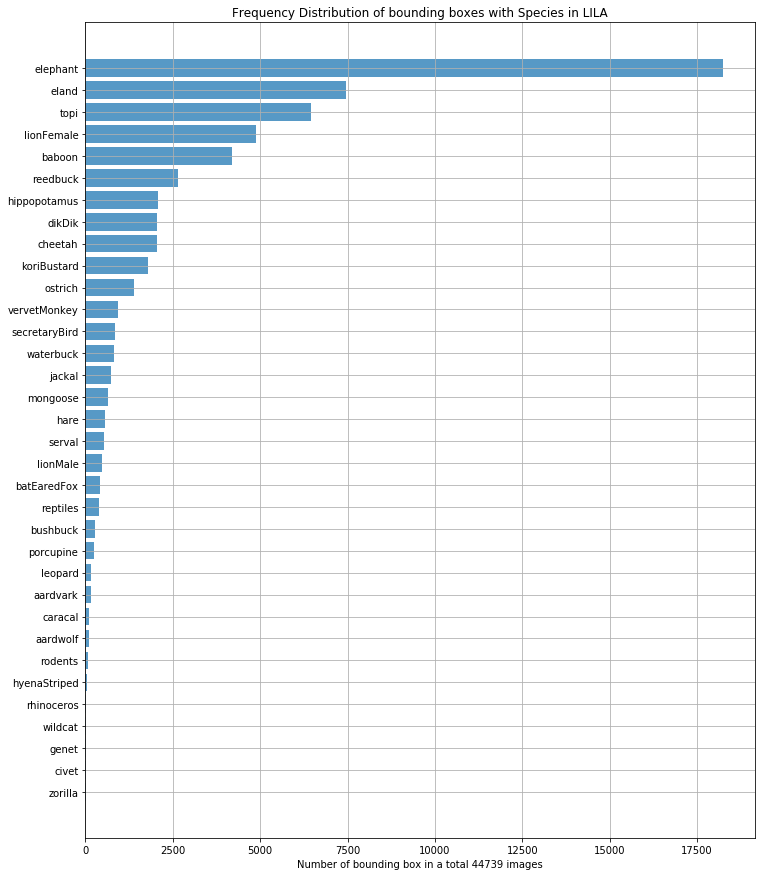

In [34]:
df_bb_species = df_bb_meta.drop_duplicates(['name', 'id_x'])
df_bb_species = df_bb_species[['name', 'id_x']]
df_bb_species_freq = df_bb_species.groupby(by=['name'], as_index=False).count()
df_bb_species_freq = df_bb_species_freq.sort_values(by='id_x')\
                            .rename(index=str, columns={'id_x':'bbox_freq'})

# df_bb_species_freq['bbox_freq_per_image'] = round((df_bb_species_freq['bbox_freq']/df_images.shape[0])*100,2)

plt.figure(figsize=(12,15))
plt.grid(True)
plt.barh(df_bb_species_freq['name'], df_bb_species_freq['bbox_freq'], align='center', alpha=0.75)
plt.title('Frequency Distribution of bounding boxes with Species in LILA')
plt.xlabel('Number of bounding box in a total {0} images'.format(df_images[~df_images['id'].isin(l)].shape[0]))

In [35]:
image_path = '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/images/'

In [36]:
# This creates a dictionary object here that can be fed into the create_tf_example function. 
# Following the format used in the [previous work]- 
# (https://github.com/Manish-rai21bit/camera-trap-detection/blob/master/Data_Model.ipynb)

# output dictionary will be - event_dict

lst = []
event_dict = {}

for bb_meta in dict_bb_meta:
    if bb_meta['image_id'] not in lst:
        lst.append(bb_meta['image_id'])
        event_dict[bb_meta['image_id']] = {'metadata' : {"SiteID": bb_meta['location'],
                                "DateTime": bb_meta['datetime'], 
                                "Season": bb_meta['season']
                                },
                                'images' : [{"Path" : image_path + bb_meta['file_name'].split('/')[-1], #points to the route of image on the disk
                                "URL" :  "placeholder", # bb_meta['url'],
                                "dim_x" :  bb_meta['width'],
                                "dim_y" :  bb_meta['height'],
                                "image_label" : "tbd", # This is the image level label if any
                                'observations' : []
                                            }
                               ]}
        
    event_dict[bb_meta['image_id']]['images'][0]['observations']\
            .append({'bb_ymin': (bb_meta['bbox'][1]), 
                     'bb_ymax':  (bb_meta['bbox'][1] + bb_meta['bbox'][3]*1), 
                     'bb_primary_label':  bb_meta['name'], 
                     'bb_xmin':  (bb_meta['bbox'][0]), 
                     'bb_xmax':  (bb_meta['bbox'][0] + bb_meta['bbox'][2]*1), 
                     'bb_label': {"species" : bb_meta['name'], 
                     "pose" : "standing/ sitting/ running"
                                  }
                    })

### Validation of bounding boxes decoding
**Do visual check on a few images to see if the bounding box encodings are correct**

In [37]:
img_list = ['S5/K03/K03_R1/S5_K03_R1_IMAG1860', 'S2/E02/E02_R2/S2_E02_R2_PICT0338',
            'S6/H07/H07_R2/S6_H07_R2_IMAG1389', 'S2/E09/E09_R3/S2_E09_R3_IMAG0362',
            'S6/J05/J05_R2/S6_J05_R2_IMAG0026'
           ]
image_dict = event_dict[img_list[4]]
image_dict

{'images': [{'Path': '/home/ubuntu/data/tensorflow/my_workspace/camera-trap-detection/data/LILA/images/S6_J05_R2_IMAG0026.JPG',
   'URL': 'placeholder',
   'dim_x': 2048,
   'dim_y': 1536,
   'image_label': 'tbd',
   'observations': [{'bb_label': {'pose': 'standing/ sitting/ running',
      'species': 'porcupine'},
     'bb_primary_label': 'porcupine',
     'bb_xmax': 1818.603140115743,
     'bb_xmin': 1138.2623970508596,
     'bb_ymax': 1334.5145344734105,
     'bb_ymin': 727.4412560462899}]}],
 'metadata': {'DateTime': '2013-02-16 19:42:58',
  'Season': 'S6',
  'SiteID': 'J05'}}

image width matches the metadata:  True
image height matches the metadata:  True


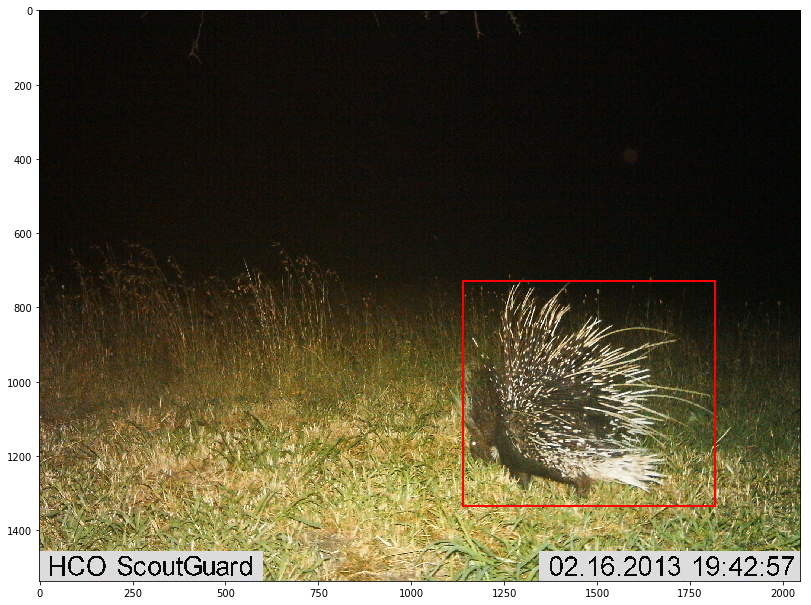

In [38]:
# Testing if the bounding boxes are correct
xmins = []
ymins = []
xmaxs = []
ymaxs = []
i = 0
for bb in image_dict['images'][0]['observations']:
    xmins.append(bb['bb_xmin'])
    ymins.append(bb['bb_ymin'])
    xmaxs.append(bb['bb_xmax'])
    ymaxs.append(bb['bb_ymax'])
        
img = image_dict['images'][0]['Path']
# encoded_jpg_io = io.BytesIO(img)
image = Image.open(img)
width, height = image.size

print("image width matches the metadata: ", image_dict['images'][0]['dim_x'] == width)
print("image height matches the metadata: ",image_dict['images'][0]['dim_y'] == height)

# Create figure and axes
fig,ax = plt.subplots(1)
fig.set_size_inches(18.5, 10.5)
# Display the image
ax.imshow(image)
for s in range(len(xmins)):
    rect = patches.Rectangle((xmins[s],ymins[s]),abs(xmaxs[s]-xmins[s]), abs(ymaxs[s] - ymins[s]),linewidth=2,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
plt.show()

### Download the images to the local
The image need to be in the local for the encoding to work on it.

Not all the images have an attached url in the event dictionary created above. Therefore, it is a good idea to:
    
    - download the images from the MSI server
    - upload it to the AWS

Future work, setup the pipeline to transfer images from the MSI to AWS and vice-versa

In [39]:
# 1. First task is to get the list of images
# This will essentially be the keys to the event_dict

# The below code creates a list of images that has to be fetched from MSI. I then 
# download the list to local and run the code to fetch the images to local
msi_image_names = list(event_dict.keys())
with open("../data/LILA/msi_image_names_Bbox_size_analysis.csv",'w') as f:
    wr = csv.writer(f)
    wr.writerow(msi_image_names)

In [40]:
print("This should be empry set: ", set(msi_image_names).intersection(set(exclude_images_list)))

This should be empry set:  set()
